In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')
from share import *

/raid/lingo/grandg/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [22]:
import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from PIL import Image
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler
from dataset import * 

In [4]:
dataset = PhotoSketchDataset(split="train", data_dir="/raid/lingo/alexisro/ControlNet/project/data/sketch/")

In [12]:
sketch_path = dataset.sketches[0]
prompt_path = dataset.prompts[0]
print(sketch_path)
print(prompt_path)

/raid/lingo/alexisro/ControlNet/project/data/sketch/sketch-rendered/width-5/00000001_01.png
./lavis/captions/00000001.json


In [13]:
example = dataset[0]

prompt:  a man and a woman playing frisbee in a field
source:  /raid/lingo/alexisro/ControlNet/project/data/sketch/sketch-rendered/width-5/00000001_01.png
target:  /raid/lingo/alexisro/ControlNet/project/data/sketch/image/00000001.jpg


In [49]:
input_image = cv2.imread(dataset.sketches[0])
print(input_image.shape, input_image.dtype)

(240, 160, 3) uint8


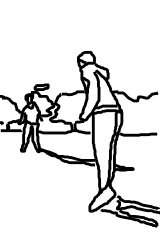

In [46]:
im_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
Image.fromarray(im_rgb, "RGB")

In [56]:
prompt = example["txt"]
print(prompt)

a man and a woman playing frisbee in a field


In [36]:
model = create_model('../models/cldm_v15.yaml').cpu()
# model.load_state_dict(load_state_dict('./models/control_sd15_scribble.pth', location='cuda'))

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [../models/cldm_v15.yaml]


In [37]:
model.load_state_dict(load_state_dict("/raid/lingo/alexisro/ControlNet/project/experiments/sketch_0503/lightning_logs/version_9/checkpoints/epoch=28-step=57999.ckpt", location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

Loaded state_dict from [/raid/lingo/alexisro/ControlNet/project/experiments/sketch_0503/lightning_logs/version_9/checkpoints/epoch=28-step=57999.ckpt]


In [61]:
with torch.no_grad():
    image_resolution = 256
    num_samples = 1
    seed = 42
    a_prompt = 'best quality, extremely detailed'
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'
    guess_mode = False
    strength = 1.0
    ddim_steps = 20
    eta = 0.0
    scale = 9.0
    
    img = resize_image(HWC3(input_image), image_resolution)
    H, W, C = img.shape

    detected_map = np.zeros_like(img, dtype=np.uint8)
    detected_map[np.min(img, axis=2) < 127] = 255

    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()

    if seed == -1:
        seed = random.randint(0, 65535)
    seed_everything(seed)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
    un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
    samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=eta,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    results = [x_samples[i] for i in range(num_samples)]

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 48, 32), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


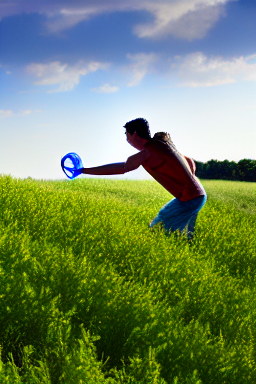

In [64]:
Image.fromarray(results[0], "RGB")